# Basal melt

In [355]:
import os
import numpy as np
import rasterio as rio
from rasterio import transform
from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio.plot import show
#from osgeo import gdal 
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from fnmatch import fnmatch
import random
from rasterio.transform import Affine


In [356]:
def writeNpToRaster(array, path, name, trans):
    r = rio.open(path + str(name) + '.tif', # save filepath for save
        'w', # 'write' mode
        driver = 'GTiff', # produces a .tif
        height = array.shape[0], # y len
        width = array.shape[1], # x len
        count = 1, # number of bands
        dtype = array.dtype, # get datatype from input array (float)
        crs = 'EPSG:3031', # polar crs
        transform = trans) # transform to projection of another rio DataReader object
    r.write(array,1)
    r.close()

In [357]:
def processMelt(Ms,dh,dair,nabla,H):
    
    rho_ow = 1028
    
    rho_i = 917
    
    #wb = (Ms/rho_i)-(rho_ow/(rho_ow-rho_i))*(dh-dair)-nabla*(H*vel)
    wb = (Ms/rho_i)-(rho_ow/(rho_ow-rho_i))*(dh-dair)-nabla*H
    
    return wb

In [513]:
years = ['2016', '2017', '2018']
seasons = ['DJF', 'MAM', 'JJA', 'SON']
ys = []
for year in years:
    for season in seasons:
        ys.append(year+season)
print(ys)

['2016DJF', '2016MAM', '2016JJA', '2016SON', '2017DJF', '2017MAM', '2017JJA', '2017SON', '2018DJF', '2018MAM', '2018JJA', '2018SON']


In [434]:
path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/'

for i in range(1,12):
    print(f'Computing melt for season {ys[i]}')
    
    # get thickness
    with rio.open(f'{path}thickness/thickness_raw/{ys[i]}.tif') as thickness:
        H_read = thickness.read(1, masked = True)
        
    # get ice shelf height
    with rio.open(f'{path}/dh_dt/dh_raw/{ys[i]}.tif') as dh:
        dh_read = dh.read(1, masked = True)
    
    # get firn air content
    with rio.open(f'{path}dair_dt/d_air_raw/{ys[i]}.tif') as dair:
        dair_read = dair.read(1, masked = True)
    
    # get ice shelf divergence
    with rio.open(f'{path}flxDiv/{ys[i]}_cropped.tif') as flx:
        flx_read = flx.read(1, masked = True)
        
    # get velocity magnitude
    with rio.open(f'{path}velocity/{ys[i]}_cropped.tif') as vel:
        vel_read = vel.read(1, masked = True)
    
    # get surface mass balance
    with rio.open(f'{path}SMB/{ys[i]}_SMB_cropped.tif') as smb:
        smb_read = smb.read(1, masked = True)
        smb_read = np.delete(smb_read,32,1)
        smb_read = np.delete(smb_read,range(35,47),0)
        smb_area = smb_read*10000 # units are mm w.e. or kg/m^2. hence multiply by 10k.

    # calculate basal melt    
    wb = processMelt(smb_area, dh_read, dair_read, flx_read, H_read)
    
    wb_year = wb*365
    
    # write to raster as test
    wb_path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/wb/'
    trans = Affine(10000.0, 0.0, -2040000.0,0.0, -10000.0, 820000.0)
    writeNpToRaster(wb_year,wb_path,ys[i],trans)
    
    wb_path = f'/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/wb/{ys[i]}.tif'
    with rio.open(wb_path, 'r+') as src:
    
        data = src.read(1, masked = True) # read it as a masked array (noData values given -9999)
    
        data = np.ma.masked_equal(data, -9999) # use np to set the masked values to nan
    
        src.write(data.filled(np.nan), 1)

Computing melt for season 2016MAM


/Users/louie.bell/opt/anaconda3/envs/gdaltest/lib/python3.9/site-packages/numpy/ma/core.py:1020: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


Computing melt for season 2016JJA
Computing melt for season 2016SON
Computing melt for season 2017DJF
Computing melt for season 2017MAM
Computing melt for season 2017JJA
Computing melt for season 2017SON
Computing melt for season 2018DJF
Computing melt for season 2018MAM
Computing melt for season 2018JJA
Computing melt for season 2018SON


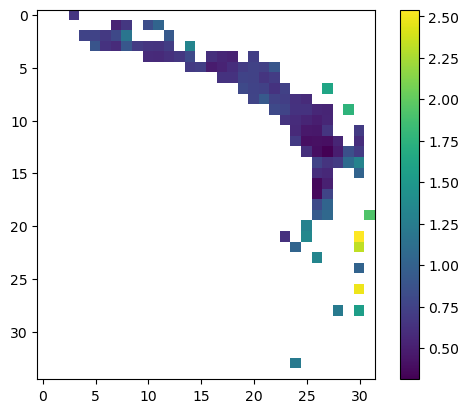

In [435]:
# here we go...
melt_2016MMA = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/wb/2017DJF.tif'
with rio.open(melt_2016MMA) as src:
    data = src.read(1, masked = True)
    fig, ax = plt.subplots()
    plt.imshow(data, cmap = 'viridis')
    hid = ax.imshow(data, cmap = 'viridis')
    plt.colorbar(hid,ax=ax)

In [436]:
# plot
# reading tiff of REMA GVIIS hillshade (Howat et al., 2022)
gvi_path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/GeorgeVI_REMA2.tiff'
gvi = rio.open(gvi_path, driver = 'GTiff')

# reading tiff of GVIIS 2020 grounding line (Boxall et al., 2022)
gviis_GLpath = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/GL_Products/2_GL_compilation/GL_compilation.shp'
gviis_GL = gpd.read_file(gviis_GLpath)
gviis_GL = gviis_GL.to_crs('EPSG:3031')

# reading lakes1gps shapefile
lakes1_path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/lakes1/lakes1.shp'
lakes1 = gpd.read_file(lakes1_path)

ais_path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'
ais = gpd.read_file(ais_path)
ais = ais.to_crs('EPSG:3031')

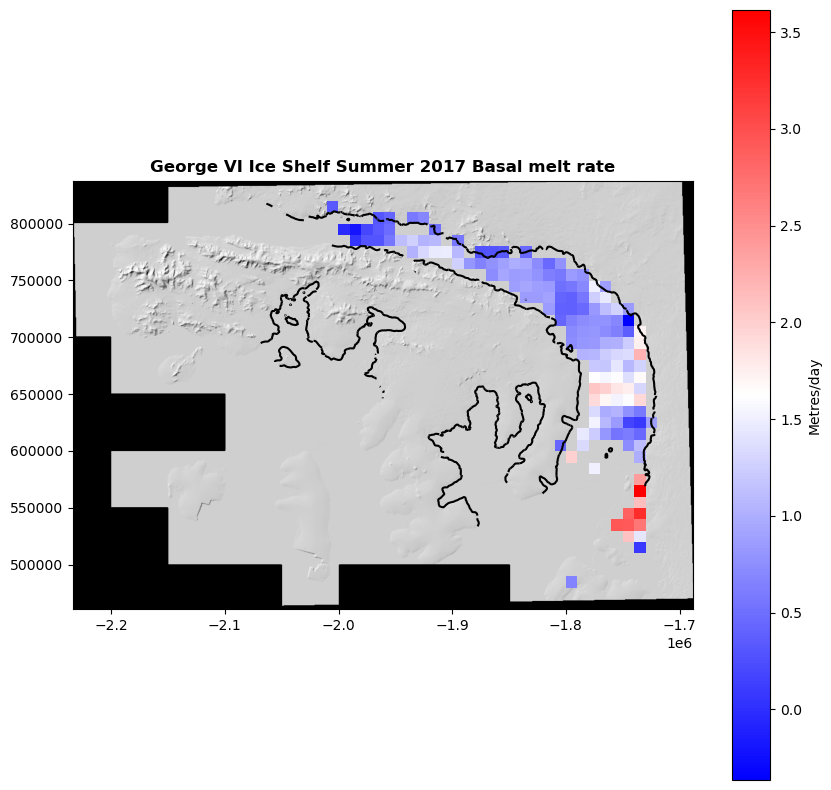

In [437]:
basal_melt = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/wb/2016JJA.tif')
bounds = gviis_GL.geometry.total_bounds
Transform = Affine(10000.00, 0.00,-2040000.00, 0.00,-10000.00, 820000.00)

fig, ax1 = plt.subplots(figsize = (10,10))
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
imgHid = ax1.imshow(basal_melt.read(1), cmap = 'bwr',
                    extent=[basal_melt.bounds.left, basal_melt.bounds.right, basal_melt.bounds.bottom, basal_melt.bounds.top]) # hidden image for colorbar reference
p1 = rio.plot.show(gvi,ax = ax1, cmap = 'Greys_r',
                   title = 'George VI Ice Shelf Summer 2017 Basal melt rate')
rio.plot.show(basal_melt, ax = p1, cmap = 'bwr')
gviis_GL.plot(ax = p1, color = 'black')
scalebar = ScaleBar(1, location="center")
ax.add_artist(scalebar)
plt.colorbar(imgHid, ax = p1, label = 'Metres/day')

In [438]:
# read in all basal melt images
wb2016MAM = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/wb/2016MAM.tif')
wb2016JJA = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/wb/2016JJA.tif')
wb2016SON = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/wb/2016SON.tif')
wb2017DJF = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/wb/2017DJF.tif')
wb2017MAM = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/wb/2017MAM.tif')
wb2017JJA = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/wb/2017JJA.tif')
wb2017SON = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/wb/2017SON.tif')
wb2018DJF = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/wb/2018DJF.tif')
wb2018MAM = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/wb/2018MAM.tif')
wb2018JJA = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/wb/2018JJA.tif')
wb2018SON = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/wb/2018SON.tif')

In [439]:
melt2016MAM = wb2016MAM.read(1) # read into array
melt2016JJA = wb2016JJA.read(1) # read into array
melt2016SON = wb2016SON.read(1) # read into array
melt2017DJF = wb2017DJF.read(1) # read into array
melt2017MAM = wb2017MAM.read(1) # read into array
melt2017JJA = wb2017JJA.read(1) # read into array
melt2017SON = wb2017SON.read(1) # read into array
melt2018DJF = wb2018DJF.read(1) # read into array
melt2018MAM = wb2018MAM.read(1) # read into array
melt2018JJA = wb2018JJA.read(1) # read into array
melt2018SON = wb2018SON.read(1) # read into array

In [440]:
melt2016MAM[np.isneginf(melt2016MAM)]=np.nan
melt2016JJA[np.isneginf(melt2016JJA)]=np.nan
melt2016SON[np.isneginf(melt2016SON)]=np.nan
melt2017DJF[np.isneginf(melt2017DJF)]=np.nan
melt2017MAM[np.isneginf(melt2017MAM)]=np.nan
melt2017JJA[np.isneginf(melt2017JJA)]=np.nan
melt2017SON[np.isneginf(melt2017SON)]=np.nan
melt2018DJF[np.isneginf(melt2018DJF)]=np.nan
melt2018MAM[np.isneginf(melt2018MAM)]=np.nan
melt2018JJA[np.isneginf(melt2018JJA)]=np.nan
melt2018SON[np.isneginf(melt2018SON)]=np.nan

In [441]:
# not my code, credit to : https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

3.6136805810695574
-0.3761124555134038


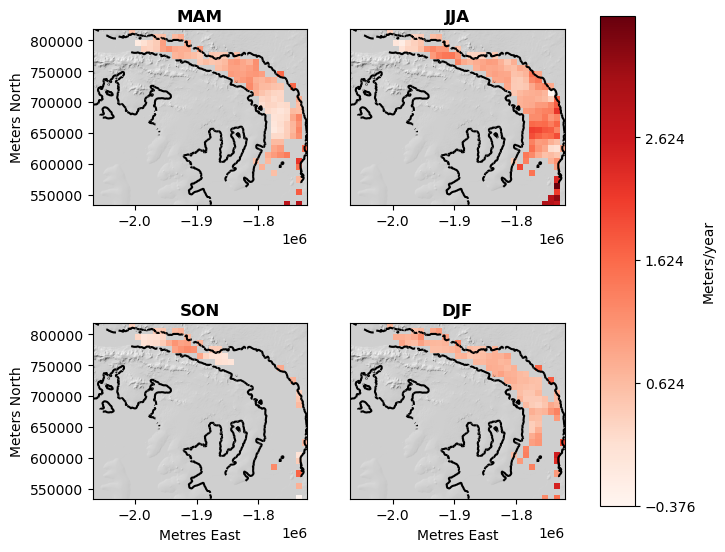

In [530]:
# PLOTTING 2016

# get the minimum value from all of the datasets
min_value = np.nanmin([np.nanmin(melt2016MAM), np.nanmin(melt2016JJA), np.nanmin(melt2016SON), np.nanmin(melt2017DJF)])

# get the max value from all of the datasets
max_value = np.nanmax([np.nanmax(melt2016MAM), np.nanmax(melt2016JJA), np.nanmax(melt2016SON), np.nanmax(melt2017DJF)])

print(max_value)
print(min_value)

norm = MidpointNormalize(vmin=min_value, vmax=max_value, midpoint=0)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (7,7))
rio.plot.show(gvi,ax = axes[0,0], cmap = 'Greys_r',
                   title = 'MAM')
gviis_GL.plot(ax = axes[0,0], color = 'black')
rio.plot.show(wb2016MAM, cmap = 'Reds', ax = axes[0,0], vmin = min_value, vmax = max_value)
rio.plot.show(gvi,ax = axes[0,1], cmap = 'Greys_r',
                   title = 'JJA')
gviis_GL.plot(ax = axes[0,1], color = 'black')
rio.plot.show(wb2016JJA, cmap = 'Reds', ax = axes[0,1], vmin = min_value, vmax = max_value)
rio.plot.show(gvi,ax = axes[1,0], cmap = 'Greys_r',
                   title = 'SON')
gviis_GL.plot(ax = axes[1,0], color = 'black')
rio.plot.show(wb2016SON, cmap = 'Reds', ax = axes[1,0], vmin = min_value, vmax = max_value)
rio.plot.show(gvi,ax = axes[1,1], cmap = 'Greys_r',
                   title = 'DJF')
gviis_GL.plot(ax = axes[1,1], color = 'black')
rio.plot.show(wb2017DJF, cmap = 'Reds', ax = axes[1,1], vmin = min_value, vmax = max_value)
cbarticks=np.arange(min_value,max_value, 1)

for ax in axes.flat:
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylabel('Meters North')
    ax.set_ylim(bounds[1], bounds[3])
    im = ax.imshow(basal_melt.read(1)) 
axes[1,0].set_xlabel('Metres East')
axes[1,1].set_xlabel('Metres East')  
axes[0,1].axes.get_yaxis().set_visible(False)
axes[1,1].axes.get_yaxis().set_visible(False)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axes[0,0].get_images()[1], cax=cbar_ax, ticks = cbarticks, label='Meters/year')
plt.show()

4.405164197741794
-4.165246541483364


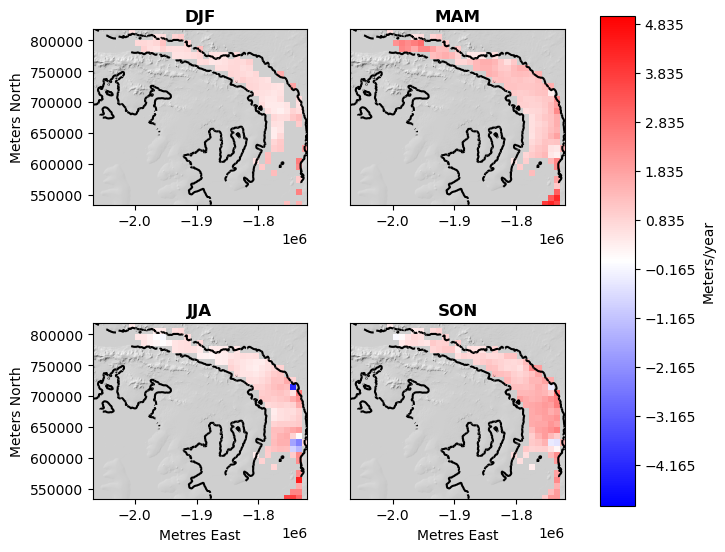

In [448]:
# PLOTTING 2017

# get the minimum value from all of the datasets
min_value = np.nanmin([np.nanmin(melt2017DJF), np.nanmin(melt2017MAM), np.nanmin(melt2017JJA), np.nanmin(melt2018SON)])

# get the max value from all of the datasets
max_value = np.nanmax([np.nanmax(melt2017DJF), np.nanmax(melt2017MAM), np.nanmax(melt2017JJA), np.nanmax(melt2018SON)])

print(max_value)
print(min_value)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (7,7))
rio.plot.show(gvi,ax = axes[0,0], cmap = 'Greys_r',
                   title = 'DJF')
gviis_GL.plot(ax = axes[0,0], color = 'black')
rio.plot.show(wb2017DJF, cmap = 'bwr', ax = axes[0,0],vmin = -5, vmax = 5)
rio.plot.show(gvi,ax = axes[0,1], cmap = 'Greys_r',
                   title = 'MAM')
gviis_GL.plot(ax = axes[0,1], color = 'black')
rio.plot.show(wb2017MAM, cmap = 'bwr', ax = axes[0,1],vmin = -5, vmax = 5)
rio.plot.show(gvi,ax = axes[1,0], cmap = 'Greys_r',
                   title = 'JJA')
gviis_GL.plot(ax = axes[1,0], color = 'black')
rio.plot.show(wb2017JJA, cmap = 'bwr', ax = axes[1,0],vmin = -5, vmax = 5)
rio.plot.show(gvi,ax = axes[1,1], cmap = 'Greys_r',
                   title = 'SON')
gviis_GL.plot(ax = axes[1,1], color = 'black')
rio.plot.show(wb2018SON, cmap = 'bwr', ax = axes[1,1],vmin = -5, vmax = 5)
cbarticks=np.arange(min_value,max_value+1, 1)

for ax in axes.flat:
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylabel('Meters North')
    ax.set_ylim(bounds[1], bounds[3])
    im = ax.imshow(basal_melt.read(1)) 
axes[1,0].set_xlabel('Metres East')
axes[1,1].set_xlabel('Metres East')  
axes[0,1].axes.get_yaxis().set_visible(False)
axes[1,1].axes.get_yaxis().set_visible(False)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axes[0,0].get_images()[1], cax=cbar_ax, ticks = cbarticks, label='Meters/year')
plt.show()

3.703660993119879
-3.4201309657982892


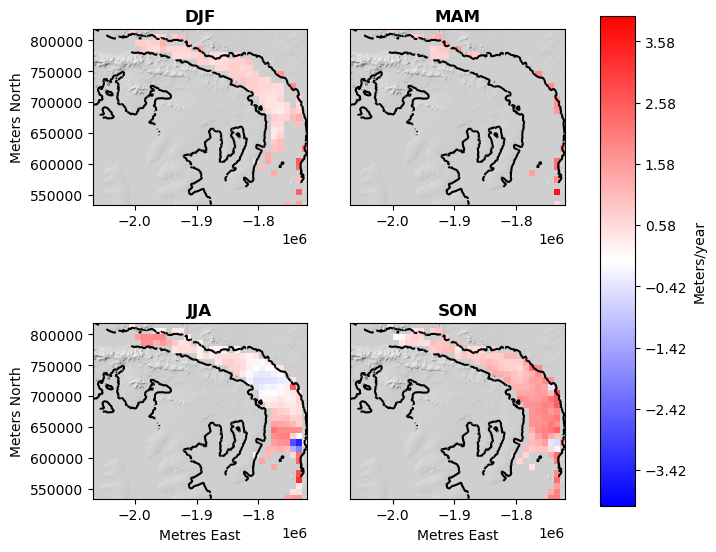

In [524]:
#PLOTTING 2018

# get the minimum value from all of the datasets
min_value = np.nanmin([np.nanmin(melt2018DJF), np.nanmin(melt2018MAM), np.nanmin(melt2018JJA), np.nanmin(melt2018SON)])

# get the max value from all of the datasets
max_value = np.nanmax([np.nanmax(melt2018DJF), np.nanmax(melt2018MAM), np.nanmax(melt2018JJA), np.nanmax(melt2018SON)])

print(max_value)
print(min_value)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (7,7))
rio.plot.show(gvi,ax = axes[0,0], cmap = 'Greys_r',
                   title = 'DJF')
gviis_GL.plot(ax = axes[0,0], color = 'black')
rio.plot.show(wb2017DJF, cmap = 'bwr', ax = axes[0,0],vmin = -4, vmax = 4)
rio.plot.show(gvi,ax = axes[0,1], cmap = 'Greys_r',
                   title = 'MAM')
gviis_GL.plot(ax = axes[0,1], color = 'black')
rio.plot.show(wb2018MAM, cmap = 'bwr', ax = axes[0,1],vmin = -4, vmax = 4)
rio.plot.show(gvi,ax = axes[1,0], cmap = 'Greys_r',
                   title = 'JJA')
gviis_GL.plot(ax = axes[1,0], color = 'black')
rio.plot.show(wb2018JJA, cmap = 'bwr', ax = axes[1,0],vmin = -4, vmax = 4)
rio.plot.show(gvi,ax = axes[1,1], cmap = 'Greys_r',
                   title = 'SON')
gviis_GL.plot(ax = axes[1,1], color = 'black')
rio.plot.show(wb2018SON, cmap = 'bwr', ax = axes[1,1],vmin = -4, vmax = 4)
cbarticks=np.arange(min_value,max_value, 1)

for ax in axes.flat:
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylabel('Meters North')
    ax.set_ylim(bounds[1], bounds[3])
    im = ax.imshow(basal_melt.read(1)) 
axes[1,0].set_xlabel('Metres East')
axes[1,1].set_xlabel('Metres East')  
axes[0,1].axes.get_yaxis().set_visible(False)
axes[1,1].axes.get_yaxis().set_visible(False)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axes[0,0].get_images()[1], cax=cbar_ax, ticks = cbarticks, label='Meters/year')
plt.show()

In [494]:
# get mean values
seasonal_means = []
seasonal_means.append(np.nanmean(melt2016MAM))
seasonal_means.append(np.nanmean(melt2016JJA))
seasonal_means.append(np.nanmean(melt2016SON))
seasonal_means.append(np.nanmean(melt2017DJF))
seasonal_means.append(np.nanmean(melt2017MAM))
seasonal_means.append(np.nanmean(melt2017JJA))
seasonal_means.append(np.nanmean(melt2017SON))
seasonal_means.append(np.nanmean(melt2018DJF))
seasonal_means.append(np.nanmean(melt2018MAM))
seasonal_means.append(np.nanmean(melt2018JJA))
seasonal_means.append(np.nanmean(melt2018SON))

stdevs = []
stdevs.append(np.nanstd(melt2016MAM))
stdevs.append(np.nanstd(melt2016JJA))
stdevs.append(np.nanstd(melt2016SON))
stdevs.append(np.nanstd(melt2017DJF))
stdevs.append(np.nanstd(melt2017MAM))
stdevs.append(np.nanstd(melt2017JJA))
stdevs.append(np.nanstd(melt2017SON))
stdevs.append(np.nanstd(melt2018DJF))
stdevs.append(np.nanstd(melt2018MAM))
stdevs.append(np.nanstd(melt2018JJA))
stdevs.append(np.nanstd(melt2018SON))

# standard error
sterrs = []
sterrs.append((np.nanstd(melt2016MAM)/(np.sqrt(np.count_nonzero(~np.isnan(melt2016MAM))))))
sterrs.append((np.nanstd(melt2016JJA)/(np.sqrt(np.count_nonzero(~np.isnan(melt2016JJA))))))
sterrs.append((np.nanstd(melt2016SON)/(np.sqrt(np.count_nonzero(~np.isnan(melt2016SON))))))
sterrs.append((np.nanstd(melt2017DJF)/(np.sqrt(np.count_nonzero(~np.isnan(melt2017DJF))))))
sterrs.append((np.nanstd(melt2017MAM)/(np.sqrt(np.count_nonzero(~np.isnan(melt2017MAM))))))
sterrs.append((np.nanstd(melt2017JJA)/(np.sqrt(np.count_nonzero(~np.isnan(melt2017JJA))))))
sterrs.append((np.nanstd(melt2017SON)/(np.sqrt(np.count_nonzero(~np.isnan(melt2017SON))))))
sterrs.append((np.nanstd(melt2018DJF)/(np.sqrt(np.count_nonzero(~np.isnan(melt2018DJF))))))
sterrs.append((np.nanstd(melt2018MAM)/(np.sqrt(np.count_nonzero(~np.isnan(melt2018MAM))))))
sterrs.append((np.nanstd(melt2018JJA)/(np.sqrt(np.count_nonzero(~np.isnan(melt2018JJA))))))
sterrs.append((np.nanstd(melt2018SON)/(np.sqrt(np.count_nonzero(~np.isnan(melt2018SON))))))

In [472]:
print(np.max(seasonal_means))
print(np.min(seasonal_means))

for i in range(0,11):
    print(ys[i], seasonal_means[i], stdevs[i])

1.9985371022589635
0.5024854516992546
2016MAM 0.711827267605505 0.4907874983483233
2016JJA 1.022545424908728 0.6473064546226293
2016SON 0.5024854516992546 0.4177900479388761
2017DJF 0.8065445582164232 0.3923333923667174
2017MAM 1.3113643185352952 0.6952492447335794
2017JJA 0.8497690341574277 0.9112535339928323
2017SON 1.9985371022589635 0.8696319580124248
2018DJF 1.2539344852109444 0.7108255553329098
2018MAM 1.3326302238607453 0.6624919907696658
2018JJA 0.6006362966642095 0.8849067063038419
2018SON 1.2063532516766855 0.5960123013726134


In [515]:
ys.remove('2016DJF')
print(len(ys))
print(len(seasonal_means))

11
11


/var/folders/0x/t41m06d52pv2j2d82wfjgn440000gn/T/ipykernel_56523/769866151.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(ys,seasonal_means, stdevs, linestyle='None', fmt='-o')


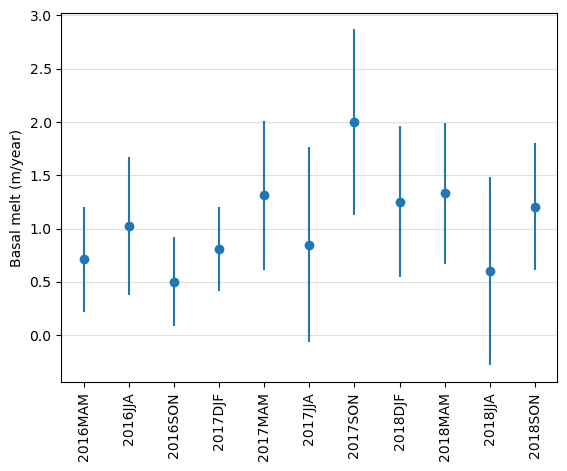

In [523]:
import matplotlib.cm as cm
fig,ax = plt.subplots()
ax.errorbar(ys,seasonal_means, stdevs, linestyle='None', fmt='-o')
ax.set_ylabel('Basal melt (m/year)', rotation = 'vertical')
ax.set_xticks(ys)
ax.set_xticklabels(ys,rotation = 'vertical')
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', alpha = 0.25)
plt.show()

In [ ]:
 maxmins = [3.6136805810695574,-0.3761124555134038,4.405164197741794,-4.165246541483364,3.703660993119879,-3.4201309657982892]

print(np.max(maxmins))
print(np.min(maxmins))
print(np.max(maxmins) - np.min(maxmins))

In [528]:
# get total range of mean melt rate
mins = [np.nanmin(melt2016MAM), np.nanmin(melt2016JJA), np.nanmin(melt2016SON), np.nanmin(melt2017DJF),
                      np.nanmin(melt2017MAM), np.nanmin(melt2017JJA), np.nanmin(melt2017SON), np.nanmin(melt2018DJF),
                      np.nanmin(melt2018MAM), np.nanmin(melt2018JJA), np.nanmin(melt2018SON)]
min_value = np.nanmin(mins)

maxs = [np.nanmax(melt2016MAM), np.nanmax(melt2016JJA), np.nanmax(melt2016SON), np.nanmax(melt2017DJF),
                      np.nanmax(melt2017MAM), np.nanmax(melt2017JJA), np.nanmax(melt2017SON), np.nanmax(melt2018DJF),
                      np.nanmax(melt2018MAM), np.nanmax(melt2018JJA), np.nanmax(melt2018SON)]
max_value = np.nanmax(maxs)

print(max_value, min_value)

seasonal_diffs = []
for i in range(0,11):
    seasonal_diffs.append(maxs[i]-mins[i])

#ys.remove('2016DJF')
for i in range(0,11):
    print(ys[i], mins[i], maxs[i], seasonal_diffs[i])
    
np.std(seasonal_diffs)

4.817700498544226 -4.165246541483364
2016MAM -0.12784434606186101 2.923817248332691 3.051661594394552
2016JJA -0.36469447841652813 3.6136805810695574 3.9783750594860856
2016SON -0.3761124555134038 1.6951018102959603 2.071214265809364
2017DJF 0.31224745390237085 2.5411165152749873 2.2288690613726163
2017MAM 0.2770694419456183 4.225542168656774 3.9484727267111555
2017JJA -4.165246541483364 4.405164197741794 8.570410739225157
2017SON -1.8715953339593436 4.817700498544226 6.68929583250357
2018DJF -1.2791885488482215 3.696929310051405 4.976117858899626
2018MAM 0.6200642555696949 3.703660993119879 3.083596737550184
2018JJA -3.4201309657982892 3.266856458713767 6.686987424512056
2018SON -0.5365032037919085 2.757514967123969 3.2940181709158773


1.9882687258235079

In [157]:
print([np.nanmax(melt2016MAM), np.nanmax(melt2016JJA), np.nanmax(melt2016SON), np.nanmax(melt2017DJF),
                      np.nanmax(melt2017MAM), np.nanmax(melt2017JJA), np.nanmax(melt2017SON), np.nanmax(melt2018DJF),
                      np.nanmax(melt2018MAM), np.nanmax(melt2018JJA), np.nanmax(melt2018SON)])

[2.0708460146955243, 2.6981890175103684, 1.0516816546701715, 0.9397190413698538, 3.3656584413101855, 3.7222190824583254, 3.6951471541760355, 3.5127434920419107, 2.365527563942774, 4.580963469288827, 1.3700217401962236]


In [158]:
print([np.nanmin(melt2016MAM), np.nanmin(melt2016JJA), np.nanmin(melt2016SON), np.nanmin(melt2017DJF),
                      np.nanmin(melt2017MAM), np.nanmin(melt2017JJA), np.nanmin(melt2017SON), np.nanmin(melt2018DJF),
                      np.nanmin(melt2018MAM), np.nanmin(melt2018JJA), np.nanmin(melt2018SON)])

[-1.1246972881188038, -2.5214271611443735, -0.985100406698961, -1.2593950835465597, -2.2227238216656597, -10.593820109460518, -8.573730251213586, -2.9002938208385927, -0.8323847737418424, -8.637379056219512, -4.259760243062293]
